<div >
<img src = "../../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_SS/blob/main/Lecture06/Notebook_SS06_Ridge.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Regularization: Lasso

## Predicting Wages

Our objective today is to construct a model of individual wages

$$
w = f(X) + u 
$$

where w is the  wage, and X is a matrix that includes potential explanatory variables/predictors. In this problem set, we will focus on a linear model of the form

\begin{align}
 ln(w) & = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p  + u 
\end{align}

were $ln(w)$ is the logarithm of the wage.

To illustrate I'm going to use a sample of the NLSY97. The NLSY97 is  a nationally representative sample of 8,984 men and women born during the years 1980 through 1984 and living in the United States at the time of the initial survey in 1997.  Participants were ages 12 to 16 as of December 31, 1996.  Interviews were conducted annually from 1997 to 2011 and biennially since then.  

Let's load the packages and the data set:

In [1]:
# install.packages("pacman") #run this line if you use Google Colab

In [2]:
#packages
require("pacman")
p_load("tidyverse","stargazer")

nlsy <- read_csv('https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/nlsy97.csv')

nlsy = nlsy  %>%   drop_na(educ) #dropea los valores faltantes (NA)

Loading required package: pacman

Rows: 1266 Columns: 994
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (994): lnw_2016, educ, black, hispanic, other, exp, afqt, mom_educ, dad_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We want to construct a model that predicts well out of sample, and we have potentially 994 regressors. We are going to regularize this regression using Ridge.

## Lasso

We first illustrate ridge regression, which can be fit using glmnet() with alpha = 1 and seeks to minimize

$$
\sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij}    \right) ^ 2 + \lambda \sum_{j=1}^{p} |\beta_j|.
$$

Notice that the intercept is not penalized. 


We are going to use Glmnet. Glmnet is a package that fits generalized linear and similar models via penalized maximum likelihood. The regularization path is computed for the lasso or elastic net penalty at a grid of values (on the log scale) for the regularization parameter lambda. The algorithm is extremely fast!

## Intuition: few predictors

In [3]:
p_load("glmnet")

In [4]:
#Vector that needs predicting
y <- nlsy$lnw_2016

# Matrix of predictos (only educ and afqt)
X <- as.matrix(nlsy  %>% select(educ,mom_educ,dad_educ))



### No penalty = OLS

In [5]:
lasso_no_pen <- glmnet(
  x = X,
  y = y,
  alpha = 1, #lasso
  lambda=0
)

In [6]:
lasso_no_pen$beta

3 x 1 sparse Matrix of class "dgCMatrix"
                  s0
educ     0.066949246
mom_educ 0.016717441
dad_educ 0.009053839

In [7]:
summary(lm(y~X))


Call:
lm(formula = y ~ X)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8605 -0.3959 -0.0439  0.3470  4.3537 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.809099   0.150243  12.041  < 2e-16 ***
Xeduc       0.066955   0.009560   7.004 4.04e-12 ***
Xmom_educ   0.016718   0.012086   1.383    0.167    
Xdad_educ   0.009051   0.010358   0.874    0.382    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8393 on 1262 degrees of freedom
Multiple R-squared:  0.06996,	Adjusted R-squared:  0.06775 
F-statistic: 31.64 on 3 and 1262 DF,  p-value: < 2.2e-16


### With Penalty

In [8]:
lasso_pen <- glmnet(
  x = X,
  y = y,
  alpha = 1, #lasso
  lambda=.2
)

In [9]:
lasso_pen$beta

3 x 1 sparse Matrix of class "dgCMatrix"
                  s0
educ     0.008334492
mom_educ .          
dad_educ .          

### Larger Penalty

In [10]:
lasso_pen_large <- glmnet(
  x = X,
  y = y,
  alpha = 1, #lasso
  lambda=1e70
)

In [11]:
lasso_pen_large$beta

3 x 1 sparse Matrix of class "dgCMatrix"
         s0
educ      0
mom_educ  .
dad_educ  .

In [12]:
### Various Penalties

In [13]:
lasso01 <- glmnet(
  x = X,
  y = y,
  alpha = 1 #lasso
)

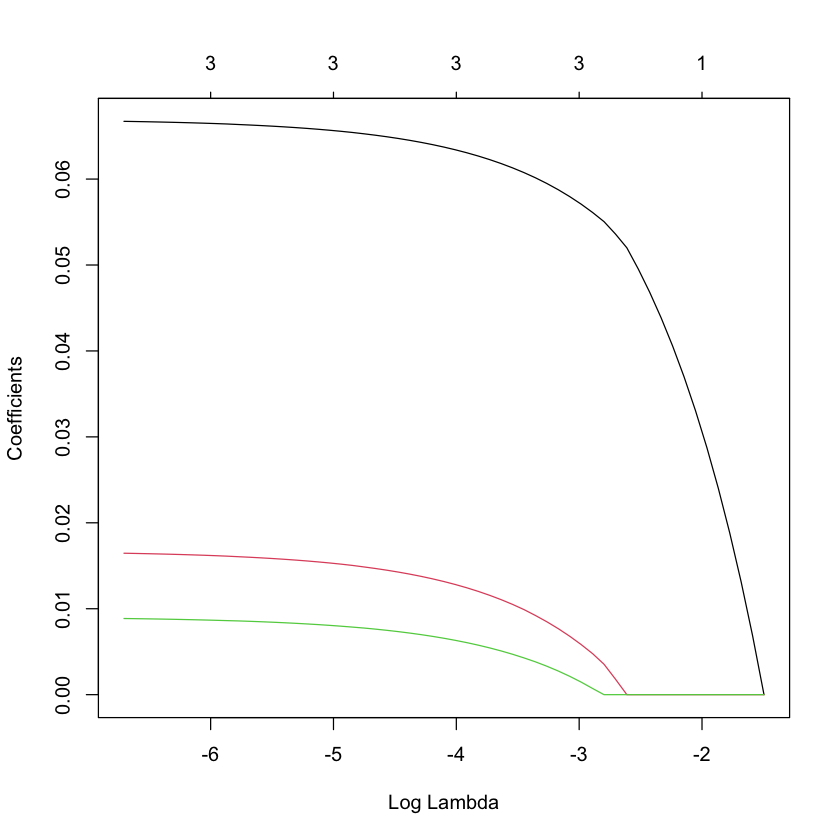

In [14]:

plot(lasso01, xvar = "lambda")

## Lasso all predictors

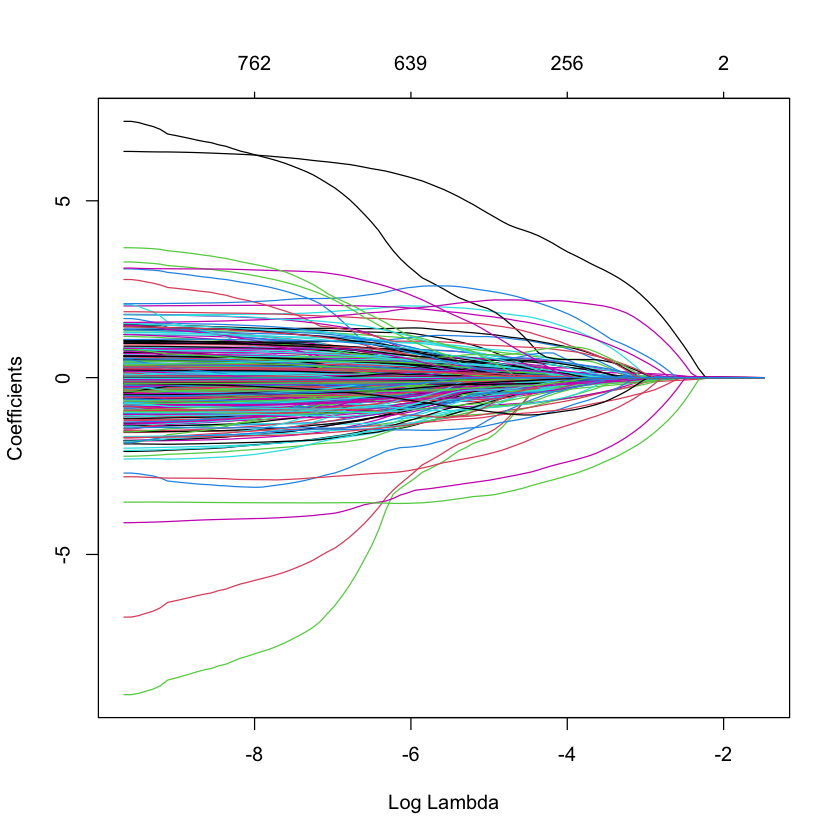

In [15]:
# Matrix of predictos (all but lnw_2016)
X0 <- as.matrix(nlsy  %>% select(-lnw_2016))

#Vector that needs predicting
y <- nlsy$lnw_2016


lasso0 <- glmnet(
  x = X0,
  y = y,
  alpha = 1 #lasso
)


plot(lasso0, xvar = "lambda")

## Selección de la penalización

In [16]:
p_load("caret")

In [17]:
set.seed(123)
fitControl <- trainControl(## 5-fold CV, 10 better
                           method = "cv",
                           number = 5)

In [18]:
lasso<-train(lnw_2016~.,
             data=nlsy,
             method = 'glmnet', 
             trControl = fitControl,
             tuneGrid = expand.grid(alpha = 1, #lasso
                                    lambda = lasso0$lambda)
              ) 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


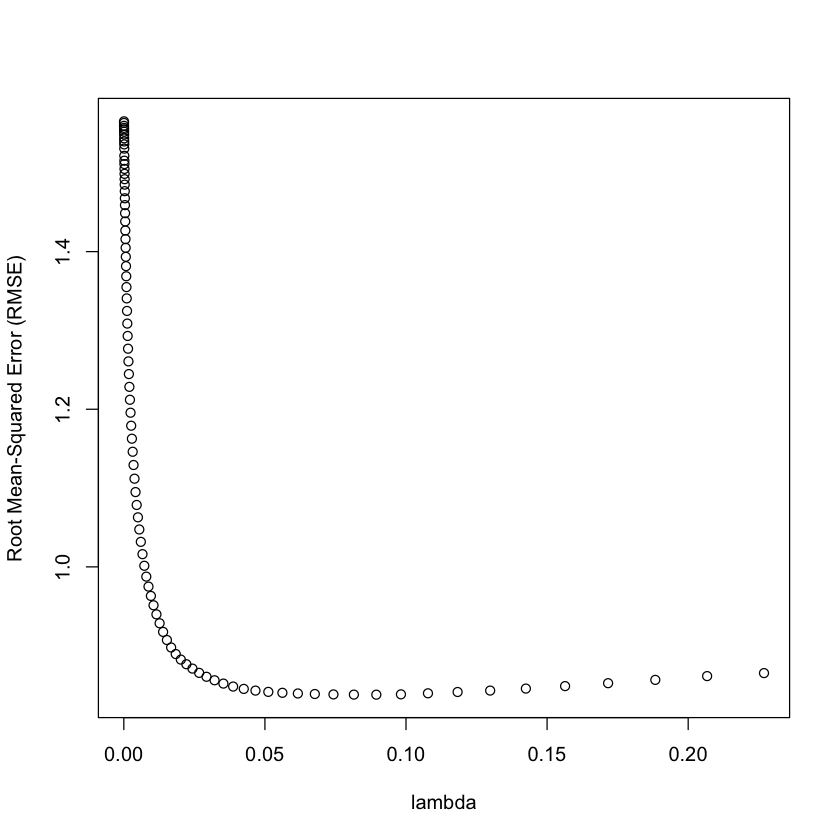

In [19]:
plot(lasso$results$lambda,
     lasso$results$RMSE,
     xlab="lambda",
     ylab="Root Mean-Squared Error (RMSE)"
     )

In [20]:
lasso$bestTune

,alpha,lambda
,<dbl>,<dbl>
79,1,0.08948257


In [21]:
coef_lasso<-coef(lasso$finalModel, lasso$bestTune$lambda)
coef_lasso

994 x 1 sparse Matrix of class "dgCMatrix"
                                      s1
(Intercept)                 2.579867e+00
educ                        2.911558e-02
black                      -5.748070e-02
hispanic                    .           
other                       .           
exp                         .           
afqt                        2.719177e-02
mom_educ                    .           
dad_educ                    .           
yhea_100_1997               .           
yhea_2000_1997              .           
yhea_2100_1997              .           
yhea_2200_1997              .           
ysaq_284_1997               .           
ysaq_285_1997               .           
ysaq_291a_1997              .           
ysaq_292_1997               .           
ysaq_293_1997               .           
ysaq_294_1997               .           
ysaq_294a_1997              .           
ysaq_295_1997               .           
ysaq_296_1997               .           
ysaq_297_1997 

### Compare to OLS fit

In [22]:
lasso$results$RMSE[which.min(lasso$results$lambda)]

[1] 1.565302

In [23]:
linear_reg<-train(lnw_2016~.,
                 data=nlsy,
                  method = 'lm', 
                  trControl = fitControl
) 


linear_reg

Warning message in predict.lm(modelFit, newdata):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning message in predict.lm(modelFit, newdata):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


Linear Regression 

1266 samples
 993 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1013, 1012, 1013, 1012, 1014 
Resampling results:

  RMSE      Rsquared    MAE     
  4.461666  0.00289532  1.621671

Tuning parameter 'intercept' was held constant at a value of TRUE

### Compare to Ridge?

In [24]:
ridge<-train(lnw_2016~.,
             data=nlsy,
             method = 'glmnet', 
             trControl = fitControl,
             tuneGrid = expand.grid(alpha = 0, #ridge
                                    lambda = lasso0$lambda)
              ) 


In [25]:
RMSE_df<-cbind(linear_reg$results$RMSE,
               ridge$results$RMSE[which.min(ridge$results$lambda)],
               lasso$results$RMSE[which.min(lasso$results$lambda)]
              )
colnames(RMSE_df)<-c("OLS","RIDGE","LASSO")
RMSE_df

OLS,RIDGE,LASSO
4.461666,1.314529,1.565302


## Elastic Net

\begin{align}
min_{\beta} EN(\beta) &= \sum_{i=1}^n (y_i-\beta_0 - \sum_{j=1}^p x_{ij}\beta_j)^2  + \lambda\left(\alpha \sum_{j=1}^p |\beta_j| + \frac{(1-\alpha)}{2} \sum_{j=1}^p (\beta_j)^2\right)
\end{align}

In [28]:
EN<-train(lnw_2016~.,
             data=nlsy,
             method = 'glmnet', 
             trControl = fitControl,
             tuneGrid = expand.grid(alpha =seq(0,1,0.1),
                                    lambda = lasso0$lambda)
              ) 

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


In [29]:
EN$bestTune

,alpha,lambda
,<dbl>,<dbl>
355,0.3,0.2067163


### Compare

#### Coeficients

In [31]:
coef_lasso<-coef(lasso$finalModel, lasso$bestTune$lambda)
coef_ridge<-coef(ridge$finalModel, ridge$bestTune$lambda)
coef_EN<-coef(EN$finalModel,EN$bestTune$lambda)

coefs_df<-cbind(coef(linear_reg$finalModel),as.matrix(coef_ridge),as.matrix(coef_lasso),as.matrix(coef_EN))
colnames(coefs_df)<-c("OLS","RIDGE","LASSO","ELASTIC_NET")
round(coefs_df,4)

,OLS,RIDGE,LASSO,ELASTIC_NET
(Intercept),-103.5985,2.8543,2.5799,2.6304
educ,-0.0605,0.0143,0.0291,0.0293
black,-0.1075,-0.1277,-0.0575,-0.0897
hispanic,0.3068,0.1469,0.0000,0.0000
other,-0.3725,-0.2744,0.0000,0.0000
exp,-0.1664,-0.0149,0.0000,0.0000
afqt,0.0258,0.0180,0.0272,0.0274
mom_educ,0.0370,0.0043,0.0000,0.0000
dad_educ,-0.0170,-0.0003,0.0000,0.0000
yhea_100_1997,0.3124,-0.0043,0.0000,0.0000


In [32]:
#### RMSE

In [33]:
RMSE_df<-cbind(linear_reg$results$RMSE,ridge$results$RMSE[which.min(ridge$results$lambda)],lasso$results$RMSE[which.min(lasso$results$lambda)],EN$results$RMSE[which.min(EN$results$lambda)])
colnames(RMSE_df)<-c("OLS","RIDGE","LASSO","EN")
RMSE_df

OLS,RIDGE,LASSO,EN
4.461666,1.314529,1.565302,1.295256
